In [1]:
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from PIL import Image,ImageFont,ImageDraw
import numpy as np
import torch
import copy
import torchvision
import os
import imageio

In [2]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
rootPath = ""
cnn = (models.vgg19(pretrained=True).features).cuda().eval()
unloader = transforms.ToPILImage()

In [4]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to("cuda")

In [5]:
def show(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.pause(0.1)  # pause a bit so that plots are updated

In [6]:
def cal_gram(featmap):
    bSize, map_num, m, n = featmap.size()
    feat = featmap.view(bSize * map_num, m * n)
    G = torch.mm(feat, feat.t())
    return G.div(bSize * map_num * m * n)

In [7]:
class content_loss(nn.Module):
    def __init__(self, content, weight):
        super().__init__()
        self.weight = weight
        self.func = nn.MSELoss()
        self.content = content.detach() * weight

    def forward(self, input):
        self.loss = self.func(input * self.weight, self.content)
        return input

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [8]:
class style_loss(nn.Module):
    def __init__(self, target, weight):
        super().__init__()
        self.weight = weight
        self.func = nn.MSELoss()
        self.target = cal_gram(target).detach() * weight

    def forward(self, input):
        self.output = input.clone()
        self.G = cal_gram(input)
        self.G.mul_(self.weight)
        self.loss = self.func(self.G, self.target)
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [9]:
def cal_loss(cnn, origin, target):
    cnn = copy.deepcopy(cnn)
    model = nn.Sequential().cuda()
    C_losses = []
    S_losses = []
    i = 0
    for L in cnn.children():
        if isinstance(L, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(L, nn.ReLU):
            name = 'relu_{}'.format(i)
            L = nn.ReLU(inplace=False)
        elif isinstance(L, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            model.add_module(name, L)
            continue
        model.add_module(name, L)

        if name in content_layers:
            contentFeat = model(origin).detach()
            C_loss = content_loss(contentFeat, content_weight)
            model.add_module("content_loss{}".format(i), C_loss)
            C_losses.append(C_loss)

        if name in style_layers:
            styleFeat = model(target).detach()
            S_loss = style_loss(styleFeat, style_weight)
            model.add_module("style_loss{}".format(i), S_loss)
            S_losses.append(S_loss)
    return model, C_losses, S_losses

In [10]:
def make_gif(up):
    filelist = []  
    root = os.getcwd()
    pathr = os.path.join(root, up)
    files = os.listdir(pathr)
    for f in files:  
        if(os.path.isfile(pathr + '/' + f)):
            if (os.path.splitext(f)[1] == ".png"):
                filelist.append(f)
    ff = sorted(filelist)
    images = []
    for f in ff:
        images.append(imageio.imread(os.path.join(pathr, f)))
    imageio.mimsave(os.path.join(pathr, 'res.gif'), images, duration=0.5)

In [11]:
def transfer(cnn, s_origin, s_target):
    up = os.path.splitext(os.path.split(s_origin)[-1])[0] \
        + '-' + os.path.splitext(os.path.split(s_target)[-1])[0] \
        + '-' + "{}-{}".format(int(content_weight), int(style_weight))
    if not os.path.exists(up):
        os.mkdir(up)
    transform = transforms.Compose([transforms.ToTensor()])
    origin = load_image(s_origin, transform, max_size=max_size)
    target = load_image(s_target, transform, shape=[origin.shape[3], origin.shape[2]])
    
    input_img = origin.clone()
    
    run = [0]
    torchvision.utils.save_image(input_img, "{}/{:03d}.png".format(up, run[0]))

    model, C_losses, S_losses = cal_loss(cnn, origin, target)
    prama = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([prama])
    while run[0] <= num_steps:
        def closure():
            prama.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(prama)
            style_score = 0
            content_score = 0
            for sl in S_losses:
                style_score += sl.backward()
            for cl in C_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % record_each == 0:
                name = "{}/{:03d}.png".format(up, run[0])
                torchvision.utils.save_image(prama.data, name)
                im = Image.open(name)
                draw = ImageDraw.Draw(im)
                newfont = ImageFont.truetype('simkai.ttf', 20)
                draw.text((0,0),"{}/{}".format(run[0], num_steps),(0,0,0),font=newfont)
                im.save(name)
            if run[0] % show_each == 0:
                print("step {}/{}, Style Loss : {:4f} Content Loss: {:4f}".format(
                    run[0], num_steps, style_score.item(), content_score.item()))
                show(prama.data)
            return style_score + content_score
        optimizer.step(closure)
    prama.data.clamp_(0, 1)
    return prama.data, up

In [24]:
max_size = 512
num_steps = 200
record_each = 10
show_each = 50
content_weight = 1
style_weight = 1e3

In [25]:
s_target = "source/styled/styled_8.jpg"
s_origin = "source/origin/lion.jpg"

step 50/200, Style Loss : 9.501931 Content Loss: 9.532875


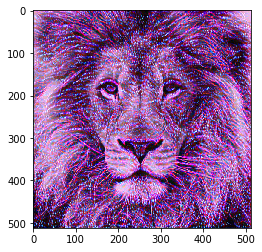

step 100/200, Style Loss : 3.074903 Content Loss: 8.846659


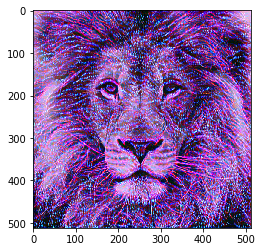

step 150/200, Style Loss : 2.106273 Content Loss: 8.047557


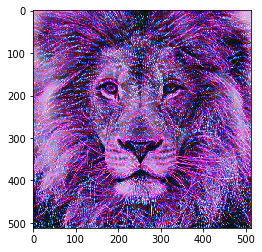

step 200/200, Style Loss : 1.607162 Content Loss: 7.731972


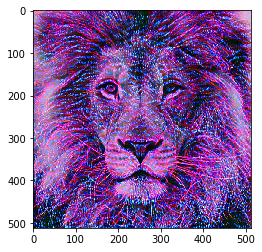

In [26]:
out, up = transfer(cnn, s_origin, s_target)

In [36]:
make_gif(up)